### Memorization

In [19]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sys
sys.path.append("..")
from data.small_context import get_datasets
from data.metrics import calculate_crps
from data.small_context import get_memorization_datasets

datasets = get_memorization_datasets()
nlls = defaultdict(dict)
mae = defaultdict(dict)

name_map = {
    "gp": "SM-GP",
    "arima": "ARIMA",
    "TCN": "TCN",
    "N-HiTS": "N-HiTS",
    "N-BEATS": "N-BEATS",
    "text-davinci-003": "GPT-3",
}

hue_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3']
palette = sns.color_palette('Dark2', len(hue_order))
palette = palette[:2] + palette[3:] + palette[2:3]

for dsname,(train,test) in datasets.items():
    with open(f'../eval/memorization/{dsname}.pkl','rb') as f:
        data_dict = pickle.load(f)

    # print(dsname)
    # print(type(data_dict['gp']['samples']))

    for model_name,preds in data_dict.items():
        print(model_name)
        if isinstance(preds['median'], np.ndarray):
            preds['median'] = pd.Series(preds['median'])
        try: 
            if 'NLL/D' not in preds:
                continue
            nll = preds['NLL/D']
            if model_name=='text-davinci-003-tuned':
                model_name='GPT3'
            nlls[model_name][dsname] = nll
            test_values = test.values if isinstance(test,pd.Series) else test

            tmae = np.abs(test_values-preds['median'].values).mean()/np.abs(test_values).mean()
            mae[model_name][dsname] = tmae
        except Exception as e:
            print(e)
        
data = []

for model_name in nlls:
    for dsname in nlls[model_name]:
        entry = {
            "model_name": model_name,
            "dataset_name": dsname,
            "nll": nlls[model_name][dsname],
            "mae": mae[model_name][dsname],
        }
        data.append(entry)

# Convert the list of dictionaries to a DataFrame
result_df = pd.DataFrame(data)

# drop all model_names except for 'gp', 'arima', 'TCN', 'text-davinci-003'
# result_df = result_df[result_df['model_name'].isin(['arima', 'TCN', 'text-davinci-003'])]
# result_df = result_df[result_df['model_name'].isin(['gp', 'arima', 'N-HiTS', 'TCN', 'text-davinci-003'])]

result_df['dataset_name'].unique()
result_df['NLL/D'] = result_df['nll']
result_df['model_name'] = result_df['model_name'].apply(lambda x: name_map[x])

n_cols = 11
n_rows = 1
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3)
fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(20, 4), constrained_layout=True, #sharex=True,
    gridspec_kw={'width_ratios': [
        4, 0.1, 1, 0.4, 
        4, 0.1, 1, 0.4, 
        4, 0.1, 1]} 
)
axes = axes.flatten()

dsname_map = {
    'IstanbulTraffic': 'Istanbul Traffic',
    'TSMCStock': 'TSMC Stock',
    'TurkeyPower': 'Turkey Power',
}

result_df['ll'] = -1 * result_df['nll']

ax_idx = 0
# Iterate through the datasets and plot the samples
for idx, dsname in enumerate(datasets.keys()):
    train,test = datasets[dsname]
    print(dsname, ax_idx)
    with open(f'eval/memorization/{dsname}.pkl','rb') as f:
        data_dict = pickle.load(f)
    ax = axes[ax_idx]
    ax_idx += 1
    if not 'text-davinci-003' in data_dict:
        print('GPT-3 not available')
        continue
    samples = data_dict['text-davinci-003']['samples']
    lower = samples.quantile(0.1,axis=0)
    upper = samples.quantile(0.9,axis=0)
    
    # if dsname == "square":
    #     print(np.min(train.values), np.max(train.values))

    pred_color = sns.color_palette('Dark2')[2]
    ax.plot(pd.concat([train,test]),color='k',label='Ground Truth', linewidth=2)
    ax.fill_between(samples.iloc[0].index, lower, upper, alpha=0.5)
    ax.plot(data_dict['text-davinci-003']['median'], color=pred_color,label='GPT-3 Median', linewidth=2)
    #ax.plot(samples.T, alpha=0.5)
    ax.set_title(dsname_map[dsname], fontsize=20)
    # turn off y axis
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

    ax = axes[ax_idx]
    ax_idx += 1

    ax.set_axis_off()

    ax = axes[ax_idx]
    ax_idx += 1
    
    sns.barplot(
        x='dataset_name',
        # x='data_type',
        # order=['Trend', 'Periodic', 'Trend + Periodic'],
        y='NLL/D',
        hue='model_name', 
        hue_order=hue_order,
        data=result_df[result_df['dataset_name'] == dsname], 
        ax=ax, 
        palette=palette,
    )
    ax.get_legend().remove()
    if idx % 3 != 2:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("NLL/D", rotation=-90, labelpad=15, fontsize=18)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.spines['left'].set_color('black')
    ax.plot(0, 0, 'vk', transform=ax.transAxes, clip_on=False, zorder=10)
    ax.margins(x=0.2)
    # ax.spines['bottom'].set_axisline_style("-|>")
    
    # ax.set_yticks([])
    # ax.set_ylim((-0.5,12))
    # ax.set_ylim(bottom=-3, top=9)
    ax.get_xaxis().set_visible(False)

    if idx % 3 != 2:
        ax = axes[ax_idx]
        ax_idx += 1
        ax.set_axis_off()

# axes[0].legend(['Ground Truth','Zero shot GPT3'],loc='upper left',fontsize=8,frameon=True,framealpha=0.7)

handles, labels = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[2].get_legend_handles_labels()
handles += handles2
labels += ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA','GPT-3']

plt.subplots_adjust(wspace=0, hspace=.5)

# # Remove unused subplots
# for idx in range(n_datasets, n_rows * n_cols):
#     fig.delaxes(axes[idx])

plt.savefig('memorization.pdf', dpi=300, bbox_inches='tight')
plt.savefig('memorization.png', dpi=300, bbox_inches='tight')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.legend(
    handles=handles,
    labels=labels,
    markerscale=1.5,
    loc='upper left',
    fontsize=20,
    ncol=4
)

plt.axis("off")
# plt.tight_layout()
plt.savefig('memorization_legend.pdf', bbox_inches='tight')
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: 'datasets/memorization/IstanbulTraffic.csv'

### Monash samples

In [20]:
from real_benchmarks import get_benchmark_test_sets

benchmarks = get_benchmark_test_sets()
# shuffle the benchmarks
for k, v in benchmarks.items():
    x, scaler = v # scaler is not used
    # seed
    np.random.seed(0)
    x = np.random.permutation(x)
    benchmarks[k] = x
    
df = pd.read_csv('eval/last_value_results.csv')
df.sort_values(by='mae')

df_paper = pd.read_csv('eval/paper_mae_raw.csv') # pdf text -> csv
datasets = df_paper['Dataset']
name_map = {
    'Aus. Electricity Demand' :'australian_electricity_demand',
    'Kaggle Weekly': 'kaggle_web_traffic_weekly',
    'FRED-MD': 'fred_md',
    'Saugeen River Flow': 'saugeenday',
    
}
datasets = [name_map.get(d, d) for d in datasets]
# lower case and repalce spaces with underscores
datasets = [d.lower().replace(' ', '_') for d in datasets]
df_paper['Dataset'] = datasets
# remove from df_paper datasets in df_paper but not in df
df_paper = df_paper[df_paper['Dataset'].isin(df['dataset'])]
df_paper = df_paper.reset_index(drop=True)
# for each dataset, add last value mae to df_paper
for dataset in df_paper['Dataset']:
    df_paper.loc[df_paper['Dataset'] == dataset, 'Last Value'] = df[df['dataset'] == dataset]['mae'].values[0]
# turn '-' into np.nan
df_paper = df_paper.replace('-', np.nan)
# convert all values to float
for method in df_paper.columns[1:]:
    df_paper[method] = df_paper[method].astype(float)
df_paper.to_csv('eval/paper_mae.csv', index=False)
# normalize each method by dividing by last value mae
for method in df_paper.columns[1:-1]: # skip dataset and last value
    df_paper[method] = df_paper[method] / df_paper['Last Value']
# sort df by minimum mae across methods
df_paper['normalized_min'] = df_paper[df_paper.columns[1:-1]].min(axis=1)
df_paper['normalized_median'] = df_paper[df_paper.columns[1:-1]].median(axis=1)
df_paper = df_paper.sort_values(by='normalized_min')
df_paper = df_paper.reset_index(drop=True)
# save as csv
df_paper.to_csv('eval/paper_mae_normalized.csv', index=False)

predictable_datasets = df_paper.head(10)['Dataset']
datasets = {k: benchmarks[k] for k in predictable_datasets}

ModuleNotFoundError: No module named 'real_benchmarks'

In [21]:
def plot_predictions(inputs, targets, medians, ax):
    sns.color_palette('Set1')
    train = pd.Series(inputs, index=range(len(inputs)))
    test = pd.Series(targets, index=range(len(inputs), len(inputs)+len(targets)))
    medians = pd.Series(medians, index=test.index)
    ax.plot(pd.concat([train,test]), color='C1',label='Ground Truth', linewidth=1)
    ax.plot(medians, color='C4',label='GPT-3 Median', linewidth=1.5)
    # ax.legend()
    # remove all ticks
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

    

def plot_pred_dataset(dataset, pred_dict, max_series=None, max_num_samples=None, show_median=True, title=None):
    hyper = pred_dict['info']['hyper']
    settings = hyper.settings
    preds = pred_dict['preds']
    medians = pred_dict['medians']
    if max_series is None:
        max_series = len(preds)
    max_series = min(max_series, len(preds))
    dataset = dataset[:max_series]
    preds = preds[:max_series]
    # separate inputs and targets
    inputs = [xy[0][-hyper.max_history:] for xy in dataset]
    targets = np.array([xy[1] for xy in dataset])
    plot_predictions(inputs, targets, medians, title)
    

In [ ]:
sns.set_palette("Set1")

D = len(datasets)  # number of datasets
N = 4  # number of series per dataset
np.random.seed(99) # 2

fig, axes = plt.subplots(D, N, figsize=(5.5*N, 4*D), dpi=100)

for i, (ds_name, dataset) in enumerate(datasets.items()):
    print(ds_name)
    path = f'eval/{ds_name}.pkl'
    with open(path, 'rb') as f:
        pred_dict = pickle.load(f)

    hyper = pred_dict['info']['hyper']
    settings = hyper.settings
    medians = pred_dict['medians']
    

    inputs = [xy[0][-hyper.max_history:] for xy in dataset]
    targets = [xy[1] for xy in dataset]
    # Select N series randomly
    # sample without replacement
    if N < len(medians):
        indices = np.random.choice(len(medians), N, replace=False)
    else:
        indices = np.arange(len(medians))
    inputs = [inputs[i] for i in indices]
    targets = [targets[i] for i in indices]
    medians = [medians[i] for i in indices]
    

    for j in range(len(indices)):
        plot_predictions(inputs[j], targets[j], medians[j], axes[i, j])
    # show title inside plot on the leftmost column
    # put the title on the left
    title = '  ' + ds_name.replace('_', ' ').title()
    title = title.replace('Us', 'US')
    axes[i, 0].set_title(title, fontsize=20, y=0.88, loc='left')

for ax in axes.flat:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C1', lw=2, label='Ground Truth'),
                    Line2D([0], [0], color='C4', lw=2, label='GPT-3 Median')]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=24, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()
plt.savefig('monash_examples.pdf', bbox_inches='tight', pad_inches=0.1)

### Darts complete

                 Dataset     NLL/D                Type      CRPS       MAE  \
0   AirPassengersDataset  5.904887               SM-GP  0.063900  0.078750   
1         AusBeerDataset  4.294716               SM-GP  0.198860  0.237520   
2      GasRateCO2Dataset  0.828726               SM-GP  0.030061  0.041435   
3     MonthlyMilkDataset  4.383407               SM-GP  0.027661  0.035353   
4        SunspotsDataset  5.927820               SM-GP  0.553448  0.678478   
..                   ...       ...                 ...       ...       ...   
3     MonthlyMilkDataset  4.288150  LLaMA-2 70B (chat)  0.060835  0.079583   
4        SunspotsDataset  4.753432  LLaMA-2 70B (chat)  0.434370  0.606687   
5            WineDataset  9.567103  LLaMA-2 70B (chat)  0.126714  0.162982   
6           WoolyDataset  7.882100  LLaMA-2 70B (chat)  0.146765  0.185450   
7       HeartRateDataset  2.192415  LLaMA-2 70B (chat)  0.082896  0.100848   

          ll  
0  -5.904887  
1  -4.294716  
2  -0.828726  
3  

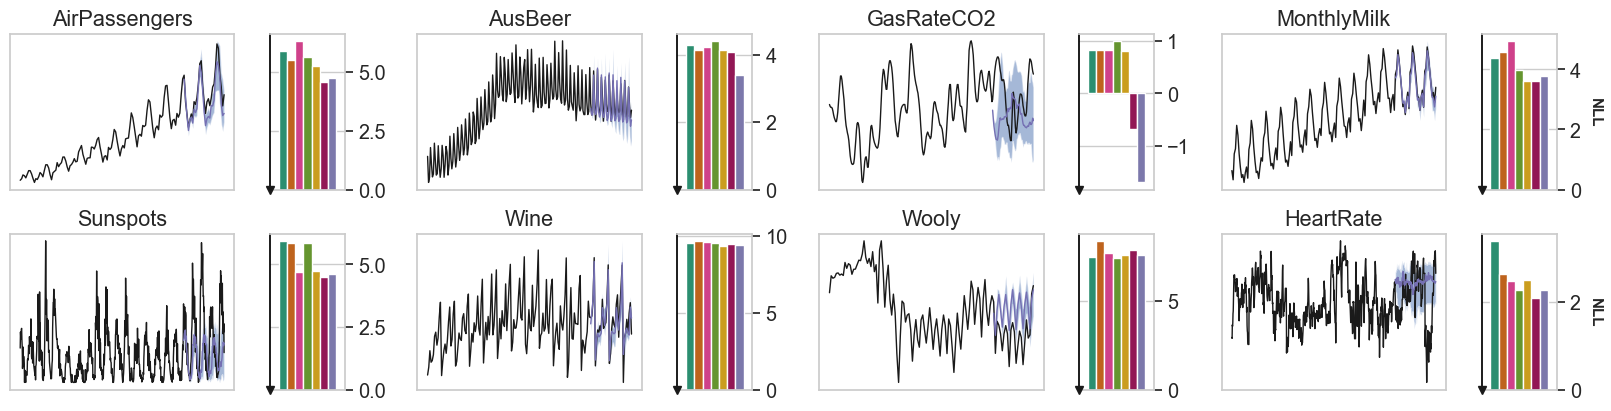

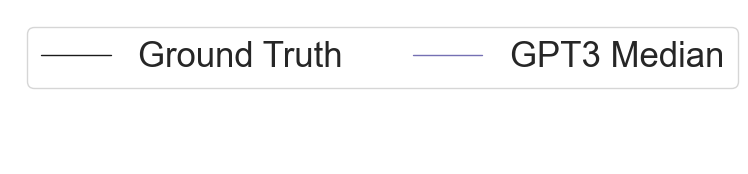

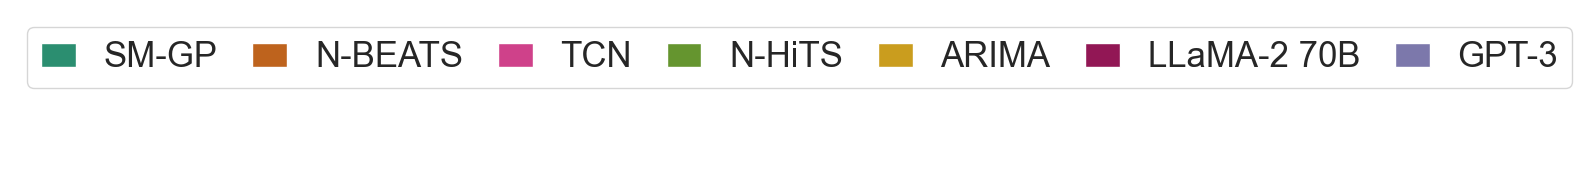

In [34]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

import sys
sys.path.append("..")
from data.small_context import get_datasets

datasets = get_datasets()

n_datasets = len(datasets)
n_cols = 15
n_rows = 2#(n_datasets + n_cols - 1) // n_cols
import seaborn as sns
sns.set(style="whitegrid", font_scale=1.3)
fig, axes = plt.subplots(
    n_rows, n_cols, 
    figsize=(16, 4), constrained_layout=True, #sharex=True,
    gridspec_kw={'width_ratios': [
        3, 0.2, 1.0, 0.2, 
        3, 0.2, 1.0, 0.2, 
        3, 0.2, 1.0, 0.2,
        3, 0.2, 1.0]}, 
)
axes = axes.flatten()

name_map = {
    "gp": "SM-GP",
    "arima": "ARIMA",
    "TCN": "TCN",
    "N-BEATS": "N-BEATS",
    "N-HiTS": "N-HiTS",
    'text-davinci-003':'GPT-3',
    'LLaMA7B': 'LLaMA7B',
    'LLaMA13B': 'LLaMA13B',
    'LLaMA30B': 'LLaMA30B', 
    'LLaMA70B': 'LLaMA70B',
    "llama1_7B": "LLaMA 7B",
    "llama1_13B": "LLaMA 13B",
    "llama1_30B": "LLaMA 30B",
    "llama1_70B": "LLaMA 70B",
    "llama2_7B": "LLaMA-2 7B",
    "llama2_13B": "LLaMA-2 13B",
    "llama2_70B": "LLaMA-2 70B",
    "llama2_7B_chat": "LLaMA-2 7B (chat)",
    "llama2_13B_chat": "LLaMA-2 13B (chat)",
    "llama2_70B_chat": "LLaMA-2 70B (chat)",
}

hue_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA']#, 'LLaMA70B']
hue_order += ["LLaMA-2 70B", 'GPT-3']
nlls = defaultdict(list)
crps = defaultdict(list)
mae = defaultdict(list)
datasets = get_datasets()
for dsname,(train,test) in datasets.items():
    # if dsname == "SunspotsDataset":
    #     continue

    # print(dsname)
    with open(f'../precomputed_outputs/darts/{dsname}.pkl','rb') as f:
        data_dict = pickle.load(f)
    for model_name,preds in data_dict.items():
        # print(f"\t{model_name}")
        if model_name in ['ada','babbage','curie']:
            continue
        if 'NLL/D' not in preds:
            continue
        nll = preds['NLL/D']
        if model_name=='text-davinci-003-tuned':
            model_name='GPT3'

        if type(preds['samples']) == np.ndarray:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'][:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)
        else:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'].values[:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)

llama_models = [
    "llama1_7B",
    "llama2_7B",
    "llama2_7B_chat",
    "llama1_13B",
    "llama2_13B",
    "llama2_13B_chat",
    "llama1_30B",
    "llama1_70B",
    "llama2_70B",
    "llama2_70B_chat",
]
for dsname,(train,test) in datasets.items():
    # if dsname == "SunspotsDataset":
    #     continue

    for model_name in llama_models:
        if model_name in ['llama2_70B', 'llama2_70B_chat']:
            fn = f'../precomputed_outputs/darts/llama_darts/{model_name}/darts-{dsname}/1.0_0.9_0.99_0.3_3_,_.pkl'
        else:
            fn = f'../precomputed_outputs/darts/llama_darts/{model_name}/darts-{dsname}/0.4_0.9_0.99_0.3_3_,_.pkl'
        with open(fn,'rb') as f:
            data_dict = pickle.load(f)

        preds = data_dict#[model_name]

        if 'NLL/D' not in preds:
            continue
        nll = preds['NLL/D']

        if type(preds['samples']) == np.ndarray:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'][:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)
        else:
            nlls[model_name].append(nll)
            crps[model_name].append(calculate_crps(test.values,preds['samples'].values[:10],10))
            tmae = np.abs(test.values-preds['median']).mean()/np.abs(test.values).mean()
            mae[model_name].append(tmae)


nlls = {k:np.array(v) for k,v in nlls.items()}
crps = {k:np.array(v) for k,v in crps.items()}
mae = {k:np.array(v) for k,v in mae.items()}


dfs = [pd.DataFrame({'Dataset':datasets.keys(),'NLL/D':v,'Type':k, 'CRPS':crps[k],'MAE':mae[k]}) for k,v in nlls.items()]
df = pd.concat(dfs)

df = df[df['Type'] != 'promptcast']
df['Type'] = df['Type'].apply(lambda x: name_map[x])

result_df = df
result_df['ll'] = -1 * result_df['NLL/D']

print(result_df)

datasets_to_plot = [
    'AirPassengersDataset', 'AusBeerDataset', 
    'GasRateCO2Dataset', 'MonthlyMilkDataset', 
    'SunspotsDataset', 'WineDataset', 
    'WoolyDataset', 'HeartRateDataset'
]
hue_order = ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA',"LLaMA-2 70B",'GPT-3']

ax_idx = 0
# Iterate through the datasets and plot the samples
for idx, dsname in enumerate(datasets_to_plot):
    train,test = datasets[dsname]

    with open(f'../precomputed_outputs/darts/{dsname}.pkl','rb') as f:
        data_dict = pickle.load(f)
    ax = axes[ax_idx]
    ax_idx += 1
    if not 'text-davinci-003' in data_dict:
        continue
    samples = data_dict['text-davinci-003']['samples']
    lower = samples.quantile(0.1,axis=0)
    upper = samples.quantile(0.9,axis=0)
    
    pred_color = sns.color_palette('Dark2')[2]
    train_test = pd.concat([train,test])

    ax.plot(train_test, color='k',label='Ground Truth', linewidth=1)
    ax.fill_between(samples.iloc[0].index, lower, upper, alpha=0.5)
    ax.plot(samples.iloc[0].index, data_dict['text-davinci-003']['median'], color=pred_color,label='GPT3 Median',linewidth=1)
    ax.set_title(dsname.replace("Dataset",""))
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)

    import matplotlib.dates as mdates
    myFmt = mdates.DateFormatter('%d')
    ax.xaxis.set_major_formatter(myFmt)
    ax.xaxis.set_major_locator(plt.MaxNLocator(2))
    # ax.set_xticklabels([0, 0, len(train_test) // 2, len(train_test)])

    ax = axes[ax_idx]
    ax_idx += 1

    ax.set_axis_off()

    ax = axes[ax_idx]
    ax_idx += 1
    
    palette = sns.color_palette('Dark2', len(hue_order))
    palette = palette[:2] + palette[3:-1] + ['#a60355'] + palette[2:3]

    _df = result_df[result_df['Dataset'] == dsname]
    print(_df)
    sns.barplot(
        x='Dataset',
        y='NLL/D',
        hue='Type', 
        hue_order=hue_order,
        data=_df, 
        ax=ax, 
        palette=palette,
    )
    ax.get_legend().remove()
    if idx % 4 != 3:
        ax.set_ylabel("")
    else:
        ax.set_ylabel("NLL", rotation=-90, labelpad=15, fontsize=11)
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()

    ax.spines['left'].set_color('black')
    ax.plot(0, 0, 'vk', transform=ax.transAxes, clip_on=False, zorder=10)
    ax.margins(x=0.15)

    # ax.set_ylim(bottom=-0.05)
    ax.get_xaxis().set_visible(False)

    if idx % 4 != 3:
        ax = axes[ax_idx]
        ax_idx += 1
        ax.set_axis_off()


handles, labels = axes[0].get_legend_handles_labels()
handles2, labels2 = axes[2].get_legend_handles_labels()
handles += handles2
labels += ['SM-GP','N-BEATS','TCN','N-HiTS','ARIMA',"LLaMA-2 70B",'GPT-3']

plt.subplots_adjust(wspace=0, hspace=.5)

plt.savefig('outputs/darts_qualitative.pdf', dpi=300, bbox_inches='tight')
plt.show()
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.legend(
    handles=handles[:2],
    labels=labels[:2],
    markerscale=1.5,
    labelspacing=0.1,
    loc='upper left',
    fontsize=25,
    ncol=8,
    frameon=True
)

plt.axis("off")
plt.tight_layout()
plt.savefig('outputs/darts_qualitative_legend_1.pdf', bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(2, 2))
ax.legend(
    handles=handles[2:],
    labels=labels[2:],
    markerscale=1.5,
    labelspacing=0.1,
    loc='upper left',
    fontsize=25,
    ncol=8,
    frameon=True,
    handlelength=1., 
    columnspacing=1.
)

plt.axis("off")
plt.tight_layout()
plt.savefig('outputs/darts_qualitative_legend_2.pdf', bbox_inches='tight')
plt.show()

### Informer

In [10]:
import os
import glob
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

import sys
sys.path.append("..")
from data.autoformer_dataset import data_dict

gt_dir = "../datasets/autoformer"
llama_results_dir = "../precomputed_outputs/autoformer/llama_2_autoformer/llama2_70B"
autoformer_results_dir = "../precomputed_outputs/autoformer/autoformer_results"
fedformer_results_dir = "../precomputed_outputs/autoformer/fedformer_results"

results = defaultdict(dict)
for fn in glob.glob(f"{llama_results_dir}/*/192/*.pkl"):
    parts = fn.split("/")[-3].split("_")
    dsname, idx = "_".join(parts[:-1]), parts[-1]

    # if "ETTh1" not in dsname:
    #     continue

    idx = int(idx)
    results[dsname][idx] = pickle.load(open(fn, "rb"))

autoformer_dsname_map = {
    "exchange_rate": "Exchange",
    "electricity": "ECL",
    "traffic": "traffic",
    "weather": "weather",
    "national_illness": "ILI",
    "ETTh1": "ETTh1",
    "ETTh2": "ETTh2",
    "ETTm1": "ETTm1",
    "ETTm2": "ETTm2",
}

df = []
for dsname in results:
    a_dsname = autoformer_dsname_map[dsname]

    if "ETT" in dsname:
        dstype = dsname
    else:
        dstype = "custom"

    for method in ["Autoformer", "Informer", "Reformer", "Transformer"]:
        try:
            feature_type = 'M'
            base_dir = f"{autoformer_results_dir}/{a_dsname}_96_192_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            if not os.path.exists(base_dir):
                feature_type = 'S'
                base_dir = f"{autoformer_results_dir}/{a_dsname}_96_192_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            pred = np.load(f"{base_dir}/pred.npy")[0]
            gt = np.load(f"{base_dir}/true.npy")[0]
        except Exception as e:
            continue

        # print(gt[:10,0])
        # print(pred[:10,0])
        # print(gt.shape)
        # print(pred.shape)
        # print("")

        mae = np.mean(np.abs(pred - gt))
        mse = np.mean((pred - gt)**2)

        df.append({
            'dsname': dsname,
            'mae': mae,
            'mse': mse,
            'method': method
        })

    for method in ["FEDformer"]:
        try:
            feature_type = 'M'
            base_dir = f"{fedformer_results_dir}/{a_dsname}_{method}_random_modes64_{dstype}_ft{feature_type}_sl96_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            # print(base_dir)
            # print(1/0)
            
            # if not os.path.exists(base_dir):
            #     feature_type = 'S'
            #     base_dir = f"{fedformer_results_dir}/{a_dsname}_96_192_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl192_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            pred = np.load(f"{base_dir}/pred.npy")[0]
            gt = np.load(f"{base_dir}/true.npy")[0]
        except Exception as e:
            continue

        # print(gt[:10,0])
        # print(pred[:10,0])
        # print(gt.shape)
        # print(pred.shape)
        # print("")

        mae = np.mean(np.abs(pred - gt))
        mse = np.mean((pred - gt)**2)

        df.append({
            'dsname': dsname,
            'mae': mae,
            'mse': mse,
            'method': method
        })

    data = data_dict["custom"](
        root_path = gt_dir,
        data_path = f"{dsname}.csv",
        flag = "test",
        size = [96, 0, 192],
        features = "M",
    )

    gt_all = pd.read_csv(f"{gt_dir}/{dsname}.csv").values[:,1:]

    gt_ordered = []
    pred_ordered = []
    mask = []
    for i in range(gt_all.shape[-1]):
        gt = gt_all[-192:,i]
        gt_ordered.append(gt)

        if (i+1) not in results[dsname]:
            pred = gt
            mask.append(0)
        else:
            r = results[dsname][i+1]
            pred = r['median'].values
            mask.append(1)

        pred_ordered.append(pred)

    # print([x.shape for x in gt_ordered])
    # print([x.shape for x in pred_ordered])

    gt_ordered = np.stack(gt_ordered, axis=1)
    pred_ordered = np.stack(pred_ordered, axis=1)
    mask = np.array(mask)

    gt = data.scaler.transform(gt_ordered)
    pred = data.scaler.transform(pred_ordered)

    # for i in range(min(pred.shape[-1], 20)):
    #     plt.plot(gt[:,i], label='gt', color='black')
    #     plt.plot(pred[:,i], label='pred', color='red')
    #     plt.legend()
    #     plt.show()

    # print(gt_all[:10,0])
    # print(gt[:10,0])
    # print(pred[:10,0])

    # print(gt.shape)
    # print(pred.shape)

    mae = np.abs(pred - gt) * mask[None,:]
    mae = np.sum(mae) / (np.sum(mask) * pred.shape[0])
    mse = (pred - gt)**2 * mask[None,:]
    mse = np.sum(mse) / (np.sum(mask) * pred.shape[0])

    df.append({
        'dsname': dsname,
        'mae': mae,
        'mse': mse,
        'method': 'LLaMA-2 70B'
    })

df = pd.DataFrame(df)
df = df[df['dsname'].isin([ 'ETTm2', 'exchange_rate', 'electricity', 'traffic', 'weather'])]
df_192 = df

In [11]:
results = defaultdict(dict)
for fn in glob.glob(f"{llama_results_dir}/*/96/*.pkl"):
    parts = fn.split("/")[-3].split("_")
    dsname, idx = "_".join(parts[:-1]), parts[-1]

    # if "ETTh1" not in dsname:
    #     continue

    idx = int(idx)
    results[dsname][idx] = pickle.load(open(fn, "rb"))

autoformer_dsname_map = {
    "exchange_rate": "Exchange",
    "electricity": "ECL",
    "traffic": "traffic",
    "weather": "weather",
    "national_illness": "ILI",
    "ETTh1": "ETTh1",
    "ETTh2": "ETTh2",
    "ETTm1": "ETTm1",
    "ETTm2": "ETTm2",
}

df = []
for dsname in results:
    a_dsname = autoformer_dsname_map[dsname]

    if "ETT" in dsname:
        dstype = dsname
    else:
        dstype = "custom"

    for method in ["Autoformer", "Informer", "Reformer", "Transformer"]:
        try:
            feature_type = 'M'
            base_dir = f"{autoformer_results_dir}/{a_dsname}_96_96_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            if not os.path.exists(base_dir):
                feature_type = 'S'
                base_dir = f"{autoformer_results_dir}/{a_dsname}_96_96_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            pred = np.load(f"{base_dir}/pred.npy")[0]
            gt = np.load(f"{base_dir}/true.npy")[0]
        except Exception as e:
            print(e)
            continue

        mae = np.mean(np.abs(pred - gt))
        mse = np.mean((pred - gt)**2)

        df.append({
            'dsname': dsname,
            'mae': mae,
            'mse': mse,
            'method': method
        })

    for method in ["FEDformer"]:
        try:
            feature_type = 'M'
            base_dir = f"{fedformer_results_dir}/{a_dsname}_{method}_random_modes64_{dstype}_ft{feature_type}_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"

            pred = np.load(f"{base_dir}/pred.npy")[0]
            gt = np.load(f"{base_dir}/true.npy")[0]
        except Exception as e:
            continue

        mae = np.mean(np.abs(pred - gt))
        mse = np.mean((pred - gt)**2)

        df.append({
            'dsname': dsname,
            'mae': mae,
            'mse': mse,
            'method': method
        })

    data = data_dict["custom"](
        root_path = gt_dir,
        data_path = f"{dsname}.csv",
        flag = "test",
        size = [96, 0, 96],
        features = "M",
    )

    gt_all = pd.read_csv(f"{gt_dir}/{dsname}.csv").values[:,1:]

    gt_ordered = []
    pred_ordered = []
    mask = []
    for i in range(gt_all.shape[-1]):
        gt = gt_all[-96:,i]
        gt_ordered.append(gt)

        if (i+1) not in results[dsname]:
            pred = gt
            mask.append(0)
        else:
            r = results[dsname][i+1]
            pred = r['median'].values
            mask.append(1)

        pred_ordered.append(pred)

    # print([x.shape for x in gt_ordered])
    # print(set([x.shape for x in pred_ordered]))

    gt_ordered = np.stack(gt_ordered, axis=1)
    pred_ordered = np.stack(pred_ordered, axis=1)
    mask = np.array(mask)

    gt = data.scaler.transform(gt_ordered)
    pred = data.scaler.transform(pred_ordered)

    mae = np.abs(pred - gt) * mask[None,:]
    mae = np.sum(mae) / (np.sum(mask) * pred.shape[0])
    mse = (pred - gt)**2 * mask[None,:]
    mse = np.sum(mse) / (np.sum(mask) * pred.shape[0])

    df.append({
        'dsname': dsname,
        'mae': mae,
        'mse': mse,
        'method': 'LLaMA-2 70B'
    })

df = pd.DataFrame(df)
df = df[df['dsname'].isin([ 'ETTm2', 'exchange_rate', 'electricity', 'traffic', 'weather'])]
df_96 = df

[Errno 2] No such file or directory: '../precomputed_outputs/autoformer/autoformer_results/ETTh2_96_96_Autoformer_ETTh2_ftS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'
[Errno 2] No such file or directory: '../precomputed_outputs/autoformer/autoformer_results/ETTh2_96_96_Informer_ETTh2_ftS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'
[Errno 2] No such file or directory: '../precomputed_outputs/autoformer/autoformer_results/ETTh2_96_96_Reformer_ETTh2_ftS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'
[Errno 2] No such file or directory: '../precomputed_outputs/autoformer/autoformer_results/ETTh2_96_96_Transformer_ETTh2_ftS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'
[Errno 2] No such file or directory: '../precomputed_outputs/autoformer/autoformer_results/ETTm1_96_96_Autoformer_ETTm1_ftS_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0/pred.npy'
[Errno 2

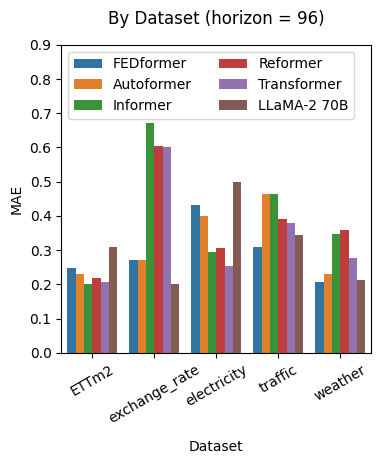

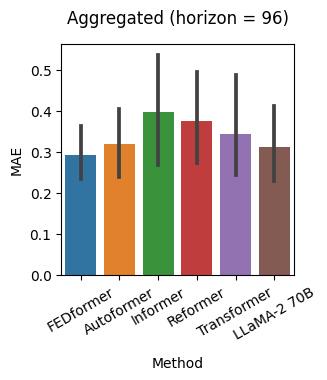

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = sns.barplot(
    data=df_96,
    x='dsname',
    order=['ETTm2', 'exchange_rate', 'electricity', 'traffic', 'weather'],
    y='mae',
    hue='method',
    hue_order=['FEDformer', 'Autoformer', 'Informer', 'Reformer', 'Transformer', 'LLaMA-2 70B'],
    ax=ax
)
for item in ax.get_xticklabels():
    item.set_rotation(30)

ax.set_xlabel("Dataset", labelpad=10)
ax.set_ylabel("MAE")
ax.set_title("By Dataset (horizon = 96)", pad=15)
ax.set_ylim(0, 0.9)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles, labels=labels,
    loc='upper left', ncols=2 #bbox_to_anchor=(1.05, 1),
)

plt.savefig("outputs/autoformer_by_dataset_96.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax = sns.barplot(
    data=df_96,
    x='method',
    y='mae',
    order=['FEDformer', 'Autoformer', 'Informer', 'Reformer', 'Transformer', 'LLaMA-2 70B'],
    ax=ax
)
ax.set_xlabel("Method", labelpad=10)
ax.set_ylabel("MAE")
ax.set_title("Aggregated (horizon = 96)", pad=15)

for item in ax.get_xticklabels():
    item.set_rotation(30)

plt.savefig("outputs/autoformer_aggregated_96.pdf", bbox_inches='tight')
plt.show()

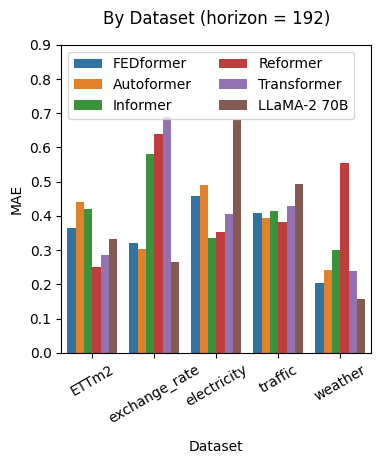

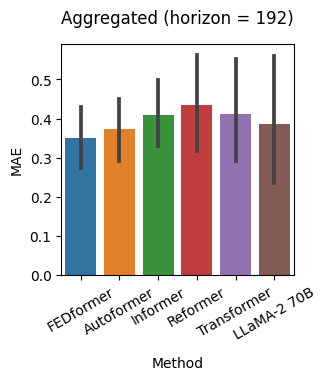

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
ax = sns.barplot(
    data=df_192,
    x='dsname',
    order=['ETTm2', 'exchange_rate', 'electricity', 'traffic', 'weather'],
    y='mae',
    hue='method',
    hue_order=['FEDformer','Autoformer', 'Informer', 'Reformer', 'Transformer', 'LLaMA-2 70B'],
    ax=ax
)
for item in ax.get_xticklabels():
    item.set_rotation(30)

ax.set_xlabel("Dataset", labelpad=10)
ax.set_ylabel("MAE")
ax.set_title("By Dataset (horizon = 192)", pad=15)
ax.set_ylim(0.0, 0.9)

handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles, labels=labels,
    loc='upper left', ncols=2 #bbox_to_anchor=(1.05, 1),
)

plt.savefig("outputs/autoformer_by_dataset_192.pdf", bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax = sns.barplot(
    data=df_192,
    x='method',
    y='mae',
    order=['FEDformer', 'Autoformer', 'Informer', 'Reformer', 'Transformer', 'LLaMA-2 70B'],
    ax=ax
)
ax.set_xlabel("Method", labelpad=10)
ax.set_ylabel("MAE")
ax.set_title("Aggregated (horizon = 192)", pad=15)

for item in ax.get_xticklabels():
    item.set_rotation(30)

plt.savefig("outputs/autoformer_aggregated_192.pdf", bbox_inches='tight')
plt.show()

In [35]:
def plot_predictions(inputs, targets, medians, ax):
    sns.color_palette('Set1')
    train = pd.Series(inputs, index=range(len(inputs)))
    test = pd.Series(targets, index=range(len(inputs), len(inputs)+len(targets)))
    medians = pd.Series(medians, index=test.index)
    ax.plot(pd.concat([train,test]), color='C1',label='Ground Truth', linewidth=1)
    ax.plot(medians, color='C4',label='GPT-3 Median', linewidth=1.5)
    # ax.legend()
    # remove all ticks
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)
    for spine in ax.spines.values():
        spine.set_edgecolor('grey')

    

def plot_pred_dataset(dataset, pred_dict, max_series=None, max_num_samples=None, show_median=True, title=None):
    hyper = pred_dict['info']['hyper']
    settings = hyper.settings
    preds = pred_dict['preds']
    medians = pred_dict['medians']
    if max_series is None:
        max_series = len(preds)
    max_series = min(max_series, len(preds))
    dataset = dataset[:max_series]
    preds = preds[:max_series]
    # separate inputs and targets
    inputs = [xy[0][-hyper.max_history:] for xy in dataset]
    targets = np.array([xy[1] for xy in dataset])
    plot_predictions(inputs, targets, medians, title)

In [ ]:
sns.set_palette("Set1")

D = len(datasets)  # number of datasets
N = 4  # number of series per dataset
np.random.seed(99) # 2

fig, axes = plt.subplots(D, N, figsize=(5.5*N, 4*D), dpi=100)

for i, (ds_name, dataset) in enumerate(datasets.items()):
    print(ds_name)
    path = f'eval/{ds_name}.pkl'
    with open(path, 'rb') as f:
        pred_dict = pickle.load(f)

    hyper = pred_dict['info']['hyper']
    settings = hyper.settings
    medians = pred_dict['medians']
    

    inputs = [xy[0][-hyper.max_history:] for xy in dataset]
    targets = [xy[1] for xy in dataset]
    # Select N series randomly
    # sample without replacement
    if N < len(medians):
        indices = np.random.choice(len(medians), N, replace=False)
    else:
        indices = np.arange(len(medians))
    inputs = [inputs[i] for i in indices]
    targets = [targets[i] for i in indices]
    medians = [medians[i] for i in indices]
    

    for j in range(len(indices)):
        plot_predictions(inputs[j], targets[j], medians[j], axes[i, j])
    # show title inside plot on the leftmost column
    # put the title on the left
    title = '  ' + ds_name.replace('_', ' ').title()
    title = title.replace('Us', 'US')
    axes[i, 0].set_title(title, fontsize=20, y=0.88, loc='left')

for ax in axes.flat:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C1', lw=2, label='Ground Truth'),
                    Line2D([0], [0], color='C4', lw=2, label='GPT-3 Median')]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=24, bbox_to_anchor=(0.5, -0.02))
plt.tight_layout()
plt.savefig('monash_examples.pdf', bbox_inches='tight', pad_inches=0.1)

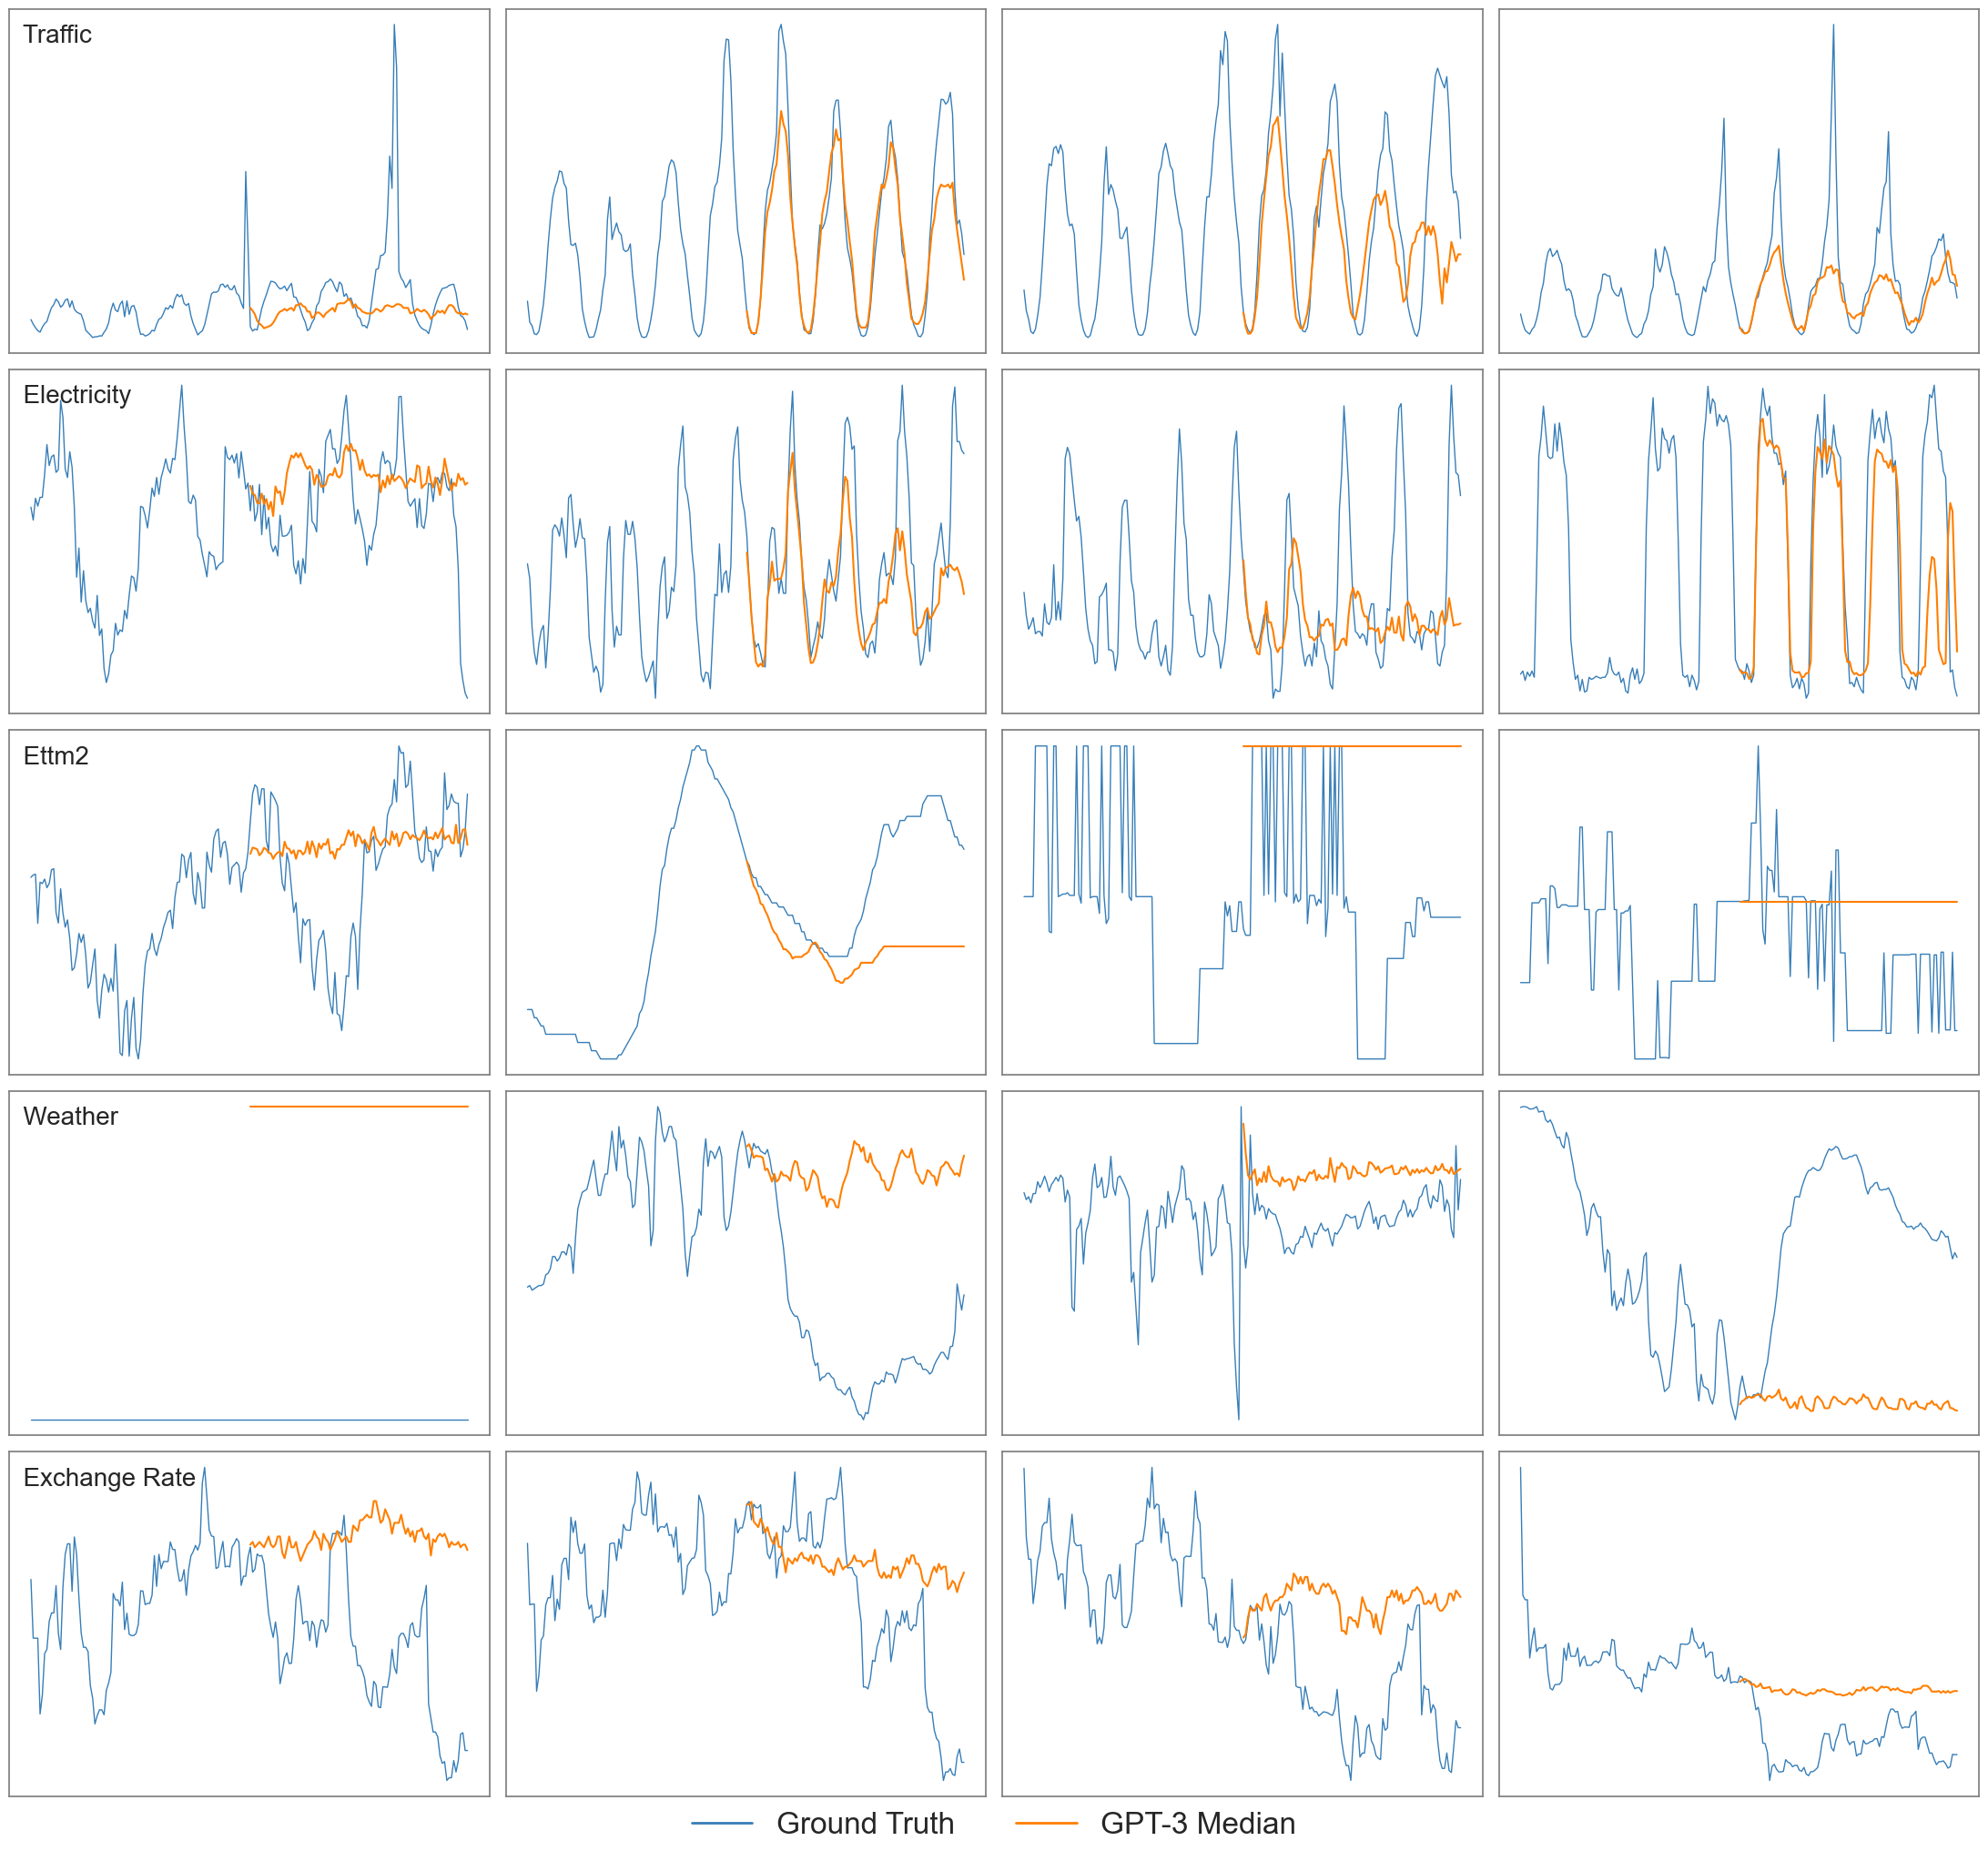

In [80]:
from data.autoformer_dataset import data_dict

autoformer_dsname_map = {
    "exchange_rate": "Exchange",
    "electricity": "ECL",
    "traffic": "traffic",
    "weather": "weather",
    "ETTm2": "ETTm2",
}

sns.set(style="white", font_scale=1)

results = defaultdict(dict)
for fn in glob.glob(f"{llama_results_dir}/*/96/*.pkl"):
    parts = fn.split("/")[-3].split("_")
    dsname, idx = "_".join(parts[:-1]), parts[-1]

    if dsname not in autoformer_dsname_map:
        continue   

    idx = int(idx)
    results[dsname][idx] = pickle.load(open(fn, "rb"))

sns.set_palette("Set1")

D = len(autoformer_dsname_map)  # number of datasets
N = 4  # number of series per dataset
np.random.seed(99) # 2

fig, axes = plt.subplots(D, N, figsize=(5.5*N, 4*D), dpi=100)

df = []
for i, dsname in enumerate(results):
    if dsname not in autoformer_dsname_map:
        continue
    
    a_dsname = autoformer_dsname_map[dsname]

    if "ETT" in dsname:
        dstype = dsname
    else:
        dstype = "custom"

    for method in ["Autoformer"]:
        try:
            feature_type = 'M'
            base_dir = f"{autoformer_results_dir}/{a_dsname}_96_96_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            if not os.path.exists(base_dir):
                feature_type = 'S'
                base_dir = f"{autoformer_results_dir}/{a_dsname}_96_96_{method}_{dstype}_ft{feature_type}_sl96_ll48_pl96_dm512_nh8_el2_dl1_df2048_fc3_ebtimeF_dtTrue_Exp_0"
            pred = np.load(f"{base_dir}/pred.npy")[0]
            gt = np.load(f"{base_dir}/true.npy")[0]
        except Exception as e:
            print(e)
            continue

    data = data_dict["custom"](
        root_path = gt_dir,
        data_path = f"{dsname}.csv",
        flag = "test",
        size = [96, 0, 96],
        features = "M",
    )

    gt_all = pd.read_csv(f"{gt_dir}/{dsname}.csv").values[:,1:]

    hist_ordered = []
    gt_ordered = []
    pred_ordered = []
    mask = []
    for k in range(gt_all.shape[-1]):
        hist = gt_all[-192:-96,k]
        gt = gt_all[-96:,k]

        hist_ordered.append(hist)
        gt_ordered.append(gt)

        if (k+1) not in results[dsname]:
            pred = gt
            mask.append(0)
        else:
            r = results[dsname][k+1]
            pred = r['median'].values
            mask.append(1)

        pred_ordered.append(pred)

    hist_ordered = np.stack(hist_ordered, axis=1)
    gt_ordered = np.stack(gt_ordered, axis=1)
    pred_ordered = np.stack(pred_ordered, axis=1)
    mask = np.array(mask)

    hist = data.scaler.transform(hist_ordered)
    gt = data.scaler.transform(gt_ordered)
    pred = data.scaler.transform(pred_ordered)
    
    #pick 4 random series
    indices = np.arange(gt.shape[-1])[mask.astype(bool)]
    indices = np.random.choice(indices, N, replace=False)
    hist = hist[:,indices]
    gt = gt[:,indices]
    pred = pred[:,indices]

    for j in range(N):
        plot_predictions(hist[:,j], gt[:,j], pred[:,j], axes[i, j])

    title = '  ' + dsname.replace('_', ' ').title()
    title = title.replace('Us', 'US')
    axes[i, 0].set_title(title, fontsize=20, y=0.88, loc='left')


for ax in axes.flat:
    ax.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False, labelbottom=False, labelleft=False)

from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='C1', lw=2, label='Ground Truth'),
                    Line2D([0], [0], color='C4', lw=2, label='GPT-3 Median')]
fig.legend(handles=legend_elements, loc='lower center', ncol=2, fontsize=24, bbox_to_anchor=(0.5, -0.03))
plt.tight_layout()

plt.savefig('outputs/informer_examples.pdf', bbox_inches='tight', pad_inches=0.1)
        